Presumed definitions:<br>
- `score`: karma score.
- `upvote_ratio`: number of upvotes divided by the total number of votes.


### Plan for this notebook
In this notebook we look into the drivers of successful posts on  `r/askscience`. Here are the steps that we take:

- Pre-process the data to handle missing values and set appropriate data types.
- Engineer some candidate features (or attributes) that can be linked to the post score 
- Visually inspect the relationship between a score 
- Get linear correlations
- Get non-linear relationship through a gradient boosted trees (GBT) model

### Distribution of scores
We have a multiscale multimodal distribution that is truncated below at zero and practically unbounded above. A reasonable transformation is good to bring this a bit under control. I considered $log_{10}(score + 0.5)$ to prevent calculating $log(0)$.

### Feature Engineering
I have focused on the scores and constructed some features 
- **temporal features**: day of week, hour, month, year
- **post title features**: length of the title, title average word length  
- **post body features**: length of the body, body average word length, body lexical diversity 
- **author features**: number of author's past posts in rscience, average score of author's past posts in rscience

These linear relationships among the features and `score` are week to moderate. I found it interesting that posts dipped during the pandemic years (2020-2022).

Because I wanted to investigate feature importance beyond linearity, I used `GradientBoostingRegressor` and plotted the relative feature importances. 

Between the linear correlation results and the non-linear regression results, I decided these features are significant enough to be part of the story, and to be part of an ML model to predict scores -- explainable AI is important:
```
['title_length',
'body_length',
'tag_past_posts',
'author_average_past_score',
'body_avg_word_length',
'body_lexical_diversity']
```
Obviously, `upvote_ratio` is has the greatest relevant importance, but it is a surrogate of the score.

### What is a successful post?
This question will always have a subjective answer, but it is probably a post with a score greater than a threshold. One might also want it to have a reasonable upvote_ratio. Perhaps A combo where the contours indicate smaller probability (more peaked surface) is a reasonable measure of success. Scrolling below all the way to the bi-variate contour plot. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Load and pre-process data

In [2]:
df = pd.read_csv('askscience_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4205 entries, 0 to 4204
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    4205 non-null   int64  
 1   title         4205 non-null   object 
 2   body          2492 non-null   object 
 3   tag           4011 non-null   object 
 4   datetime      4205 non-null   object 
 5   author        4205 non-null   object 
 6   score         4205 non-null   float64
 7   upvote_ratio  4205 non-null   float64
 8   url           4205 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 295.8+ KB


In [3]:
df.shape

(4205, 9)

In [4]:
df.columns

Index(['Unnamed: 0', 'title', 'body', 'tag', 'datetime', 'author', 'score',
       'upvote_ratio', 'url'],
      dtype='object')

In [5]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,title,body,tag,datetime,author,score,upvote_ratio,url
0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,1343.0,0.93,https://www.reddit.com/r/askscience/comments/z...
1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.0,0.91,https://www.reddit.com/r/askscience/comments/z...
2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,2218.0,0.92,https://www.reddit.com/r/askscience/comments/z...
3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.0,0.83,https://www.reddit.com/r/askscience/comments/z...
4,Are there cells in humans (or other mammals) t...,NaN,Medicine,2022-12-09 01:11:34,Velym,14.0,0.89,https://www.reddit.com/r/askscience/comments/z...


In [6]:
# datetime column as datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
# inspect numeric columns; notice score values grow in magnitudes
print(df.describe())

                            datetime         score  upvote_ratio
count                           4205   4205.000000   4205.000000
mean   2019-11-15 13:31:33.268965632   3730.471106      0.765719
min              2010-10-29 12:18:12      0.000000      0.170000
25%              2018-01-11 04:47:32      4.000000      0.590000
50%              2020-10-31 19:41:48     35.000000      0.840000
75%              2022-02-27 08:43:02   7472.000000      0.920000
max              2022-12-09 13:06:01  83382.000000      1.000000
std                              NaN   5577.606541      0.177537


Text(0, 0.5, 'Frequency')

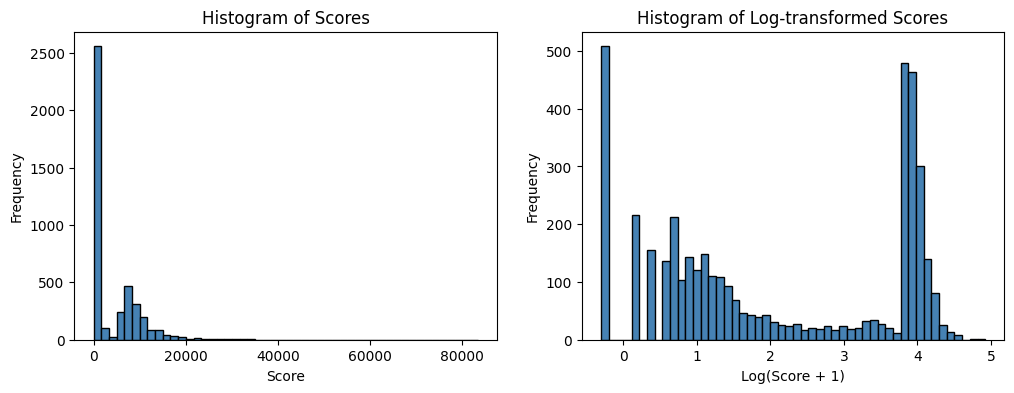

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# scores
axs[0].hist(df['score'], bins=50, color='steelblue', edgecolor='black')
axs[0].set_title('Histogram of Scores')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Frequency')

# log10(scores); add a small constant to avoid log(0) errors
axs[1].hist(np.log10(df['score'] + .5), bins=50, color='steelblue', edgecolor='black')
axs[1].set_title('Histogram of Log-transformed Scores')
axs[1].set_xlabel('Log(Score + 1)')
axs[1].set_ylabel('Frequency')

# notice the multi-modality

Text(0, 0.5, 'Frequency')

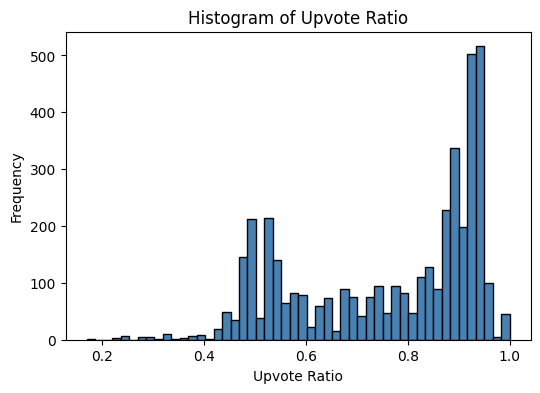

In [9]:
plt.figure(figsize=(6, 4))
plt.hist(df['upvote_ratio'], bins=50, color='steelblue', edgecolor='black')
plt.title('Histogram of Upvote Ratio')
plt.xlabel('Upvote Ratio')
plt.ylabel('Frequency')
# also multi-modal

In [10]:
# investigate unique tags
df['tag'].unique()

array(['Human Body', 'META', 'Physics', 'Medicine', 'Biology',
       'Neuroscience', 'Paleontology', 'COVID-19', 'Earth Sciences',
       'Astronomy', 'Psychology', nan, 'Social Science', 'Meta',
       'Engineering', 'Planetary Sci.', 'Chemistry', 'Anthropology',
       'Computing', 'Linguistics', 'Mathematics',
       'First image of a black hole', 'Ecology', 'Dog Cognition AMA',
       'CERN AMA', 'Archaeology', 'Earth Sciences and Biology',
       'Economics', 'Materials Science', '  Linguistics',
       'Political Science', 'Interdisciplinary', 'Food'], dtype=object)

In [11]:
# a couple of tags are duplicates
df['tag'] = df['tag'].replace({'META': 'Meta', '  Linguistics': 'Linguistics'})

In [12]:
# are there any columns with empty cells?
for col in df.columns:
    L = len(df[df[col].isnull()])
    print(f'{col}: {L}')

title: 0
body: 1713
tag: 194
datetime: 0
author: 0
score: 0
upvote_ratio: 0
url: 0


In [13]:
# fill in missing tag values as Unknown
df['tag'] = df['tag'].fillna('Unknown')

In [14]:
# handle missing body values as empty strings
df['body'] = df['body'].fillna('')

## Some feature engineering

In [15]:
# temporal features
df['hour'] = df['datetime'].dt.hour.astype(int)
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month.astype(int)
df['year'] = df['datetime'].dt.year.astype(int)

In [16]:
# length of the title and body 
df['title_length'] = df['title'].apply(len)
df['body_length'] = df['body'].apply(len)

In [17]:
# sort by datetime to facilitate creating features based on past activity 
df = df.sort_values('datetime')

In [18]:
# number of past posts in a particulr tag
df['tag_past_posts'] = df.groupby('tag').cumcount()
df['tag_past_posts'] = df['tag_past_posts'] - 1
# replace -1 with 0 where tag appears for 1st time
df['tag_past_posts'] = df['tag_past_posts'].clip(lower=0)


In [19]:
# number of author's past posts in rscience
df['author_past_posts'] = df.groupby('author').cumcount()
df['author_past_posts'] = df['author_past_posts'] - 1
# replace -1 with 0 where tag appears for 1st time
df['author_past_posts'] = df['author_past_posts'].clip(lower=0)


In [20]:
# average score of author's past posts
df['author_average_past_score'] = df.groupby('author')['score'].apply(
    lambda x: x.expanding().mean().shift(1)).reset_index(level=0, drop=True)

# fill missing values with the median overall score 
# if I set to 0, it doesn't distinguish between new authors and authors past score of 0
average_score_all_authors = df['score'].median()
df['author_average_past_score'] = df['author_average_past_score'].fillna(average_score_all_authors)

# Note: I only know what happend within the timeframe of the dataset. 
# Likely this data is censored, where some authors had made contributions 
# earlier than the min timestamp reported. So the calculations of past posts 
# and average past score will not reflect what's happened before then.


# Note to self: expanding() is an expanding moving window that slides down a series.
# the expanding window starts from the first row and includes all 
# rows up to and including the current row. Example below
# data = pd.DataFrame({'A': ['a', 'a', 'b', 'b', 'a'], 'B': [1, 2, 3, 4, 5]})
# df.groupby('A')['B'].apply(lambda x: x.expanding().mean().shift(1))

df.columns

Index(['title', 'body', 'tag', 'datetime', 'author', 'score', 'upvote_ratio',
       'url', 'hour', 'day_of_week', 'month', 'year', 'title_length',
       'body_length', 'tag_past_posts', 'author_past_posts',
       'author_average_past_score'],
      dtype='object')

In [21]:
# investigate linear correlations
numerical_cols = ['score', 
                  'upvote_ratio',
                  'hour', 
                  'day_of_week', 
                  'month', 
                  'year', 
                  'title_length',
                  'body_length', 
                  'tag_past_posts', 
                  'author_past_posts',
                  'author_average_past_score']
correlation_matrix = df[numerical_cols].corr()
print(correlation_matrix['score'])

score                        1.000000
upvote_ratio                 0.548324
hour                        -0.111899
day_of_week                 -0.005694
month                        0.022059
year                        -0.168896
title_length                 0.219878
body_length                 -0.118955
tag_past_posts              -0.265478
author_past_posts            0.061396
author_average_past_score    0.503336
Name: score, dtype: float64


<Axes: >

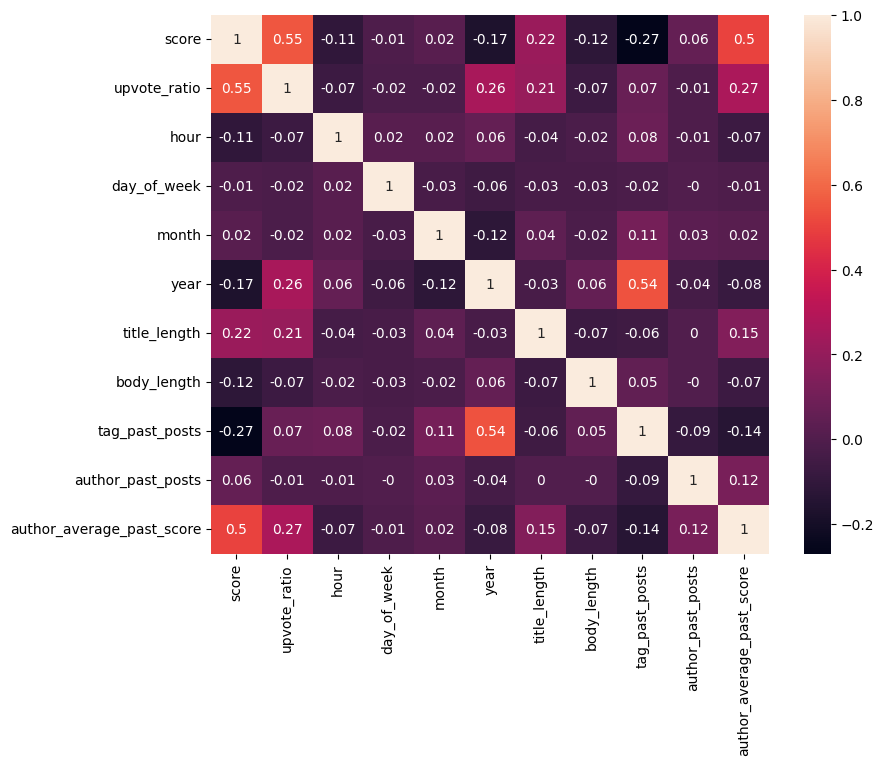

In [22]:
# heat map of linear correlations
plt.figure(figsize=(9, 7))
sns.heatmap(np.round(correlation_matrix, 2), annot=True)

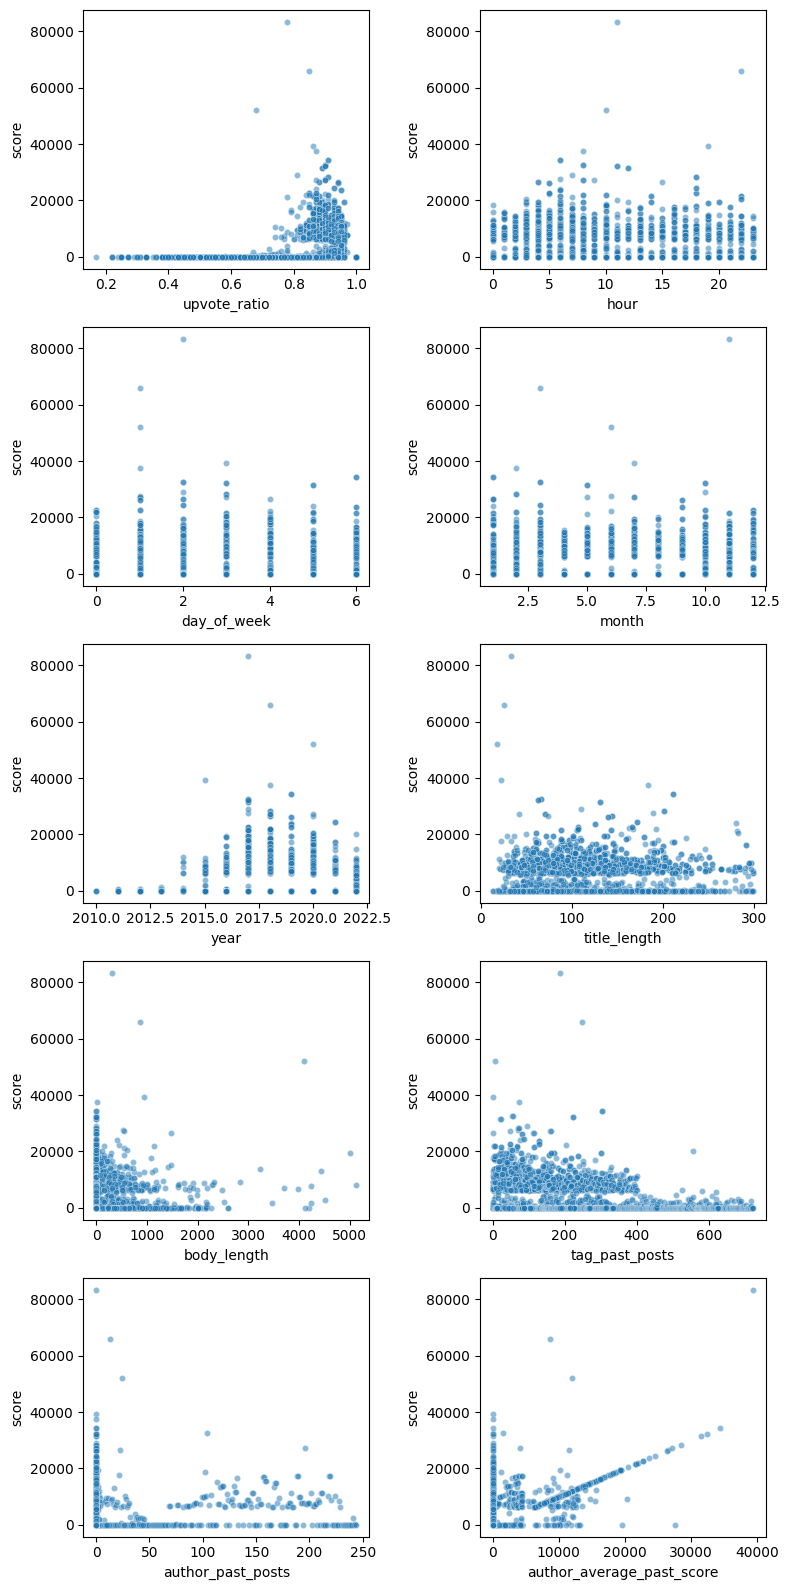

In [23]:
# scatter plot by each feature
fig, axes = plt.subplots(5, 2, figsize=(8, 16))
axes = axes.flatten()
for i, col in enumerate(numerical_cols[1:]):
    sns.scatterplot(data=df, x=col, y='score', ax=axes[i], s=20 ,alpha=0.5)
    
# remove the unused subplot
#fig.delaxes(axes[-1])
plt.tight_layout()

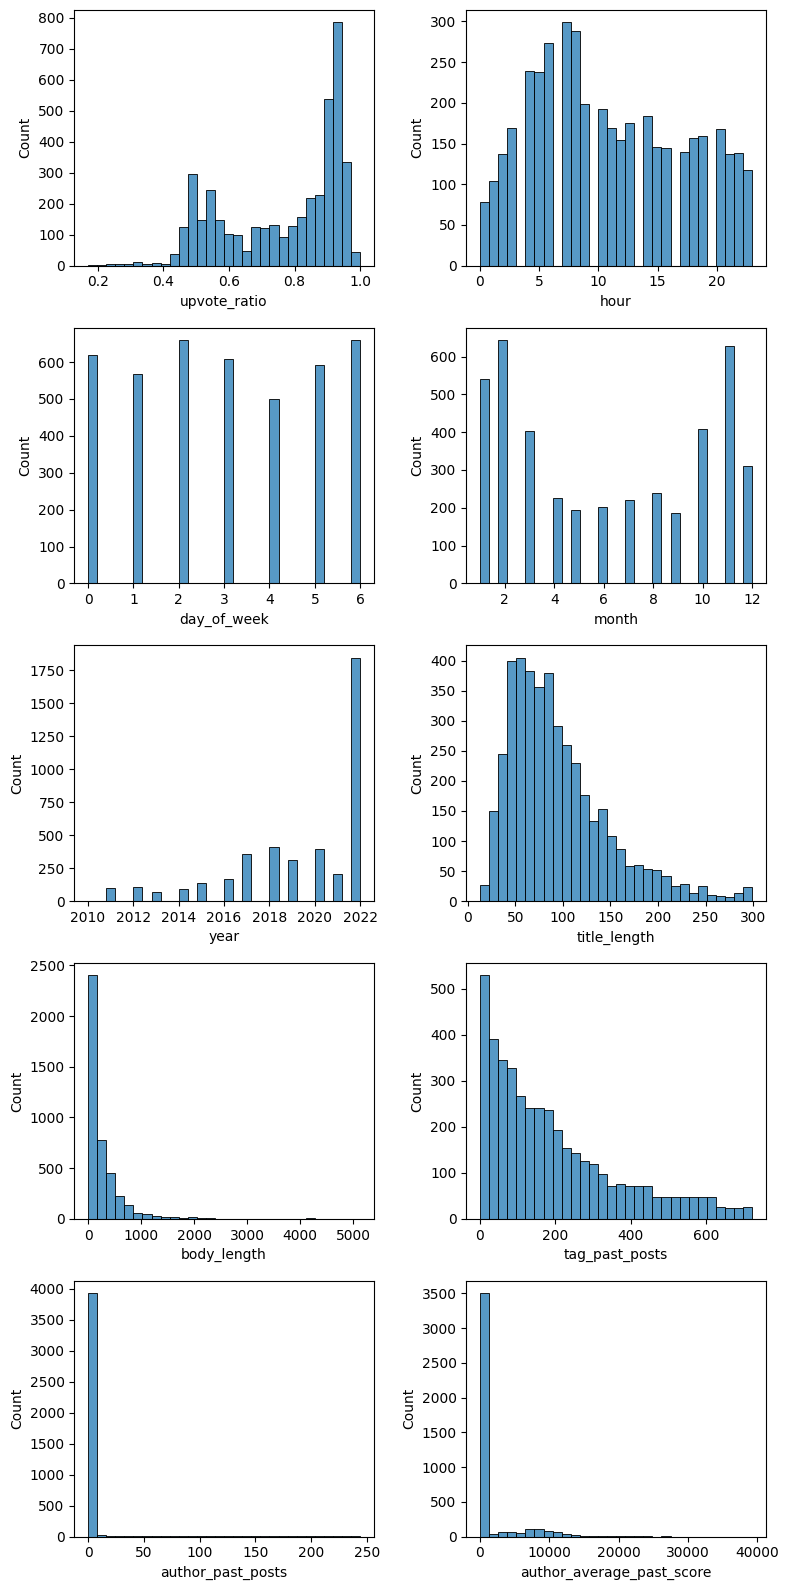

In [24]:
# histogram by each feature
fig, axes = plt.subplots(5, 2, figsize=(8, 16))
axes = axes.flatten()
for i, col in enumerate(numerical_cols[1:]):
    sns.histplot(data=df, x=col, bins=30, ax=axes[i])
plt.tight_layout()

In [25]:
# not all tags are created equal!
df.groupby('tag')['score'].size().sort_values()

tag
Food                             1
Political Science                1
CERN AMA                         1
Materials Science                1
Dog Cognition AMA                1
First image of a black hole      1
Meta                             2
Earth Sciences and Biology       2
Ecology                          2
Interdisciplinary                3
Economics                       14
Archaeology                     15
Social Science                  20
Anthropology                    23
Linguistics                     36
Paleontology                    47
Computing                       58
Psychology                      90
Mathematics                    102
Neuroscience                   107
Planetary Sci.                 111
Engineering                    190
Unknown                        194
COVID-19                       218
Chemistry                      229
Astronomy                      272
Earth Sciences                 318
Medicine                       336
Human Body      

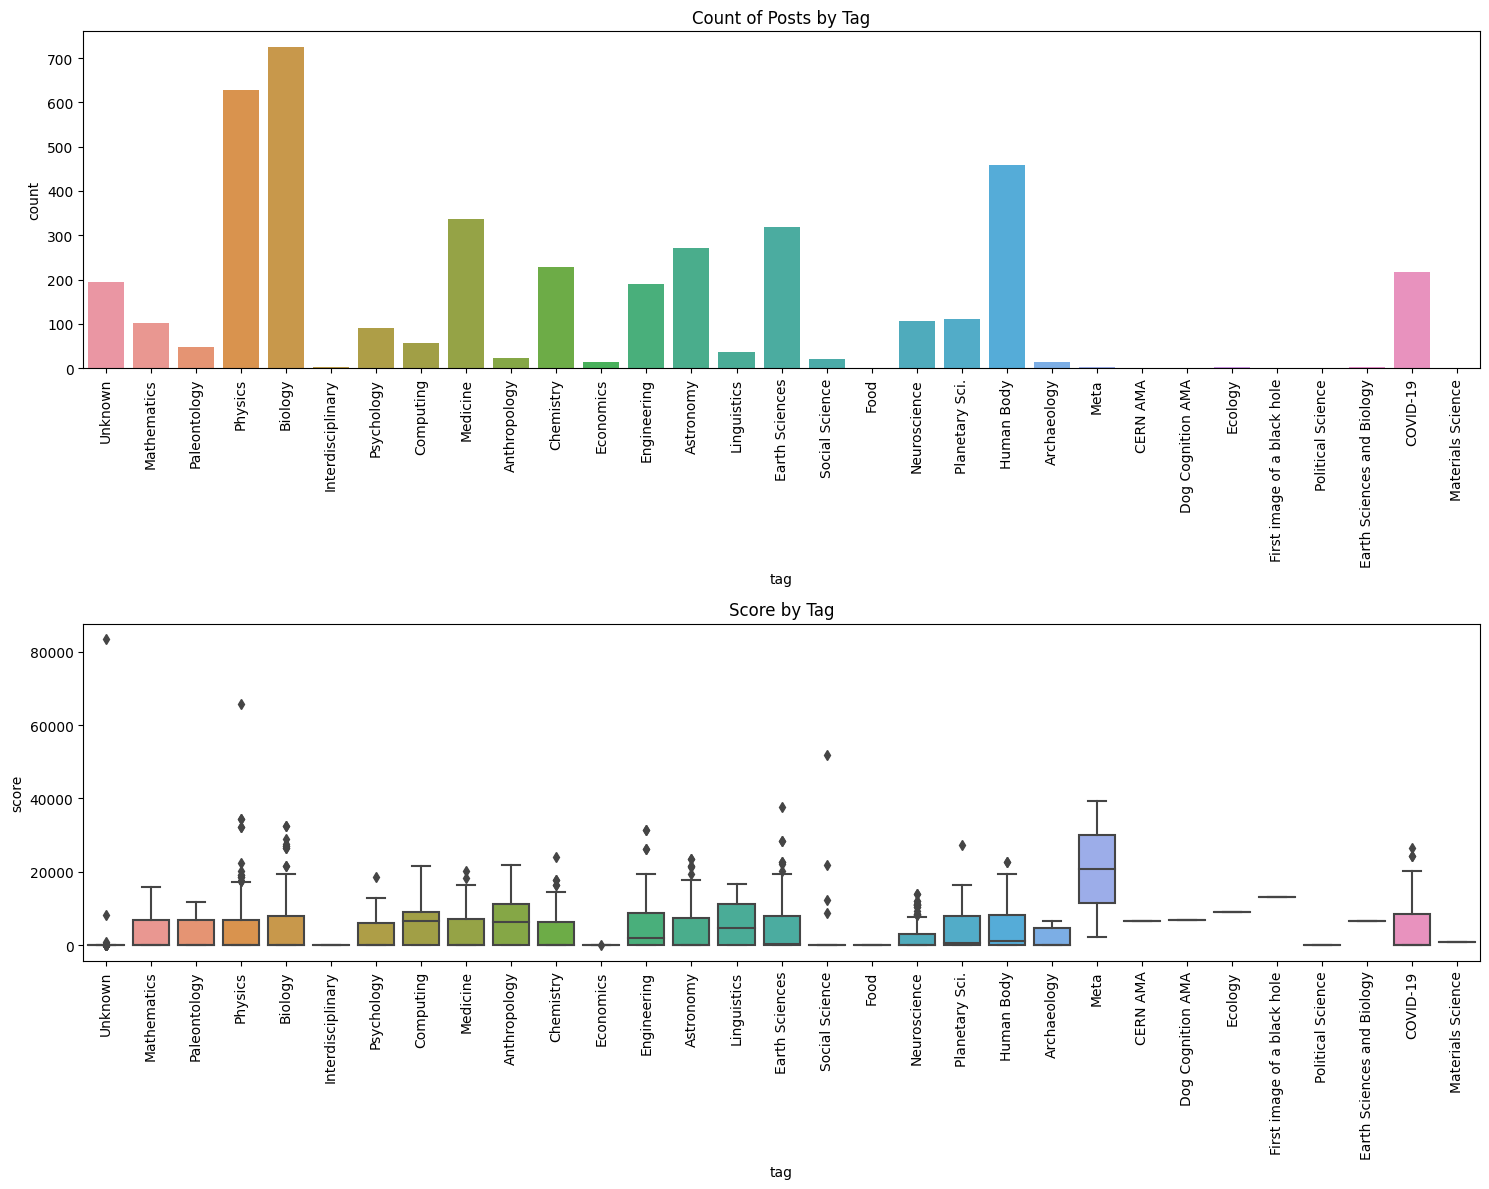

In [26]:
# some tags have low numbers of posts but might have high scores (e.g. 'Meta')
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
sns.countplot(data=df, x='tag', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_title('Count of Posts by Tag')
sns.boxplot(data=df, x='tag', y='score', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
ax[1].set_title('Score by Tag')
plt.tight_layout()

In [27]:
# what about the text in body sophistication of the text?

df['body_avg_word_length'] = df['body'].apply(
    lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0)
# realizing many post bodies are empty, this is zero-inflated

df['title_avg_word_length'] = df['title'].apply(
    lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0)


df['body_lexical_diversity'] = df['body'].apply(
    lambda x: len(set(x.split())) / len(x.split()) if x and x.split() else 0)

score                        1.000000
upvote_ratio                 0.548324
hour                        -0.111899
day_of_week                 -0.005694
month                        0.022059
year                        -0.168896
title_length                 0.219878
body_length                 -0.118955
tag_past_posts              -0.265478
author_past_posts            0.061396
author_average_past_score    0.503336
body_avg_word_length        -0.164988
title_avg_word_length       -0.122336
body_lexical_diversity      -0.325946
Name: score, dtype: float64


<Axes: >

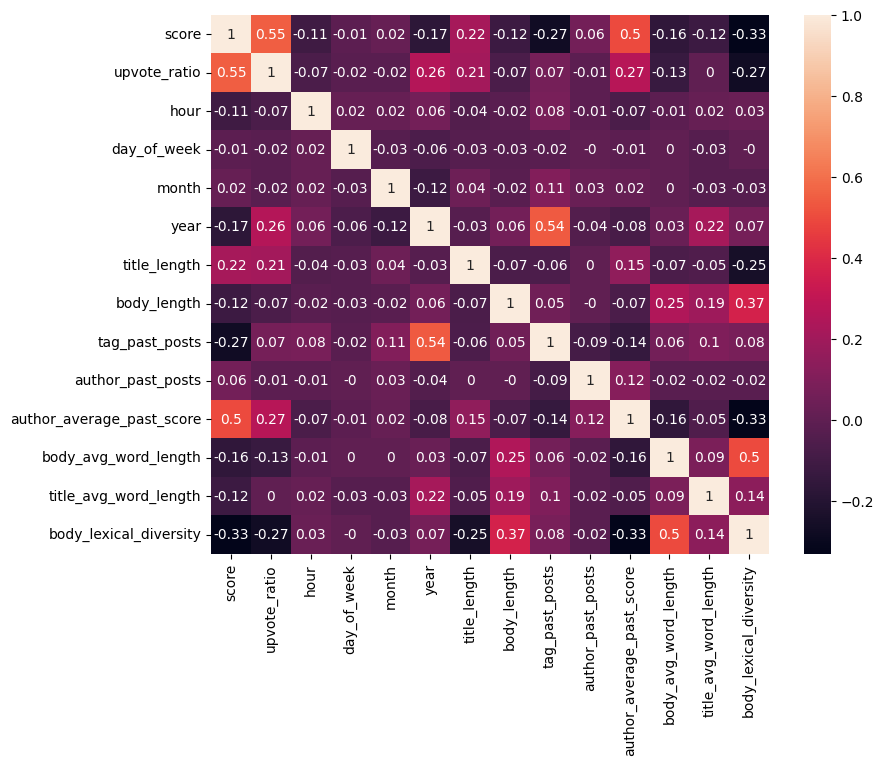

In [28]:
new_cols = ['body_avg_word_length', 
            'title_avg_word_length',
            'body_lexical_diversity']
# add the two new features to the previously calculated ones
updated_numerical_cols = numerical_cols + new_cols
# get updated corr matrix and heatplot
updated_correlation_matrix = df[updated_numerical_cols].corr()
print(updated_correlation_matrix['score'])
plt.figure(figsize=(9, 7))
sns.heatmap(np.round(updated_correlation_matrix, 2), annot=True)

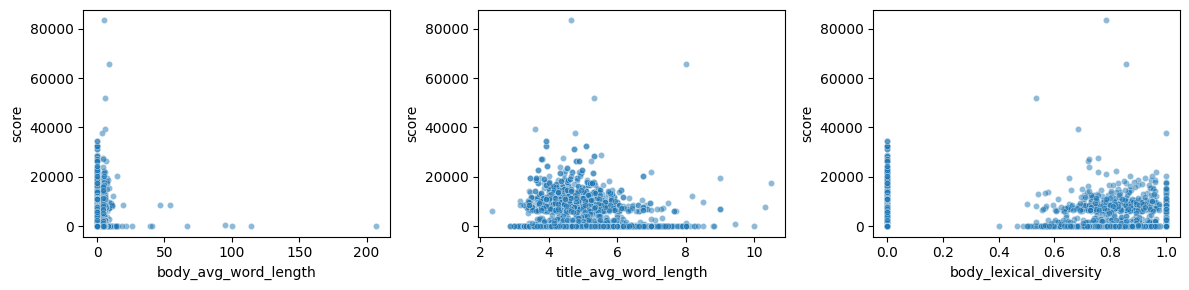

In [29]:
# scatter plots of the two new features
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes = axes.flatten()
for i, col in enumerate(new_cols):
    sns.scatterplot(data=df, x=col, y='score', ax=axes[i], s=20 ,alpha=0.5)
plt.tight_layout()

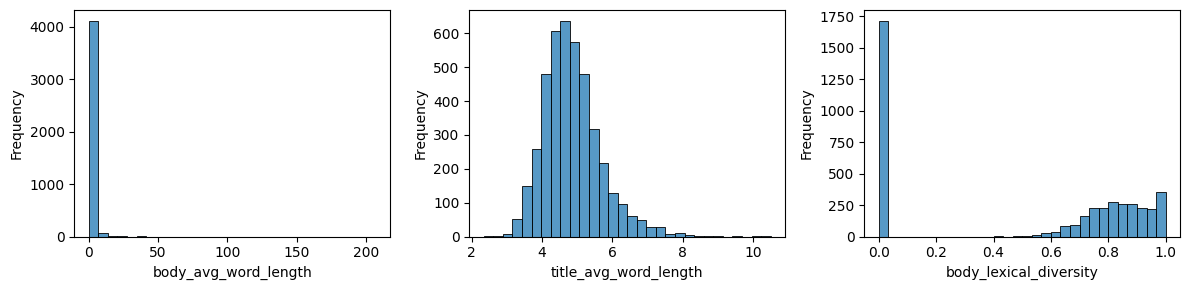

In [30]:
# histograms of the two new features
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes = axes.flatten()
for i, col in enumerate(new_cols):
    sns.histplot(data=df, x=col, bins=30, ax=axes[i])
    axes[i].set_ylabel('Frequency')
plt.tight_layout()

In [31]:
# TODO. It is a nice idea to impute tag where 'Unknown is used' 
# perhaps based using the title in a model to predict tag

In [32]:
# I consider feature importances using GBR because I obeserved non-linearities

'''
# first do some minimal hyper-parameter tuning

X = df[updated_numerical_cols].drop('score', axis=1)  
y = np.log10(df['score'] + .5)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [20, 30, 40]
grid['learning_rate'] = [.0001, .001, 0.01]
grid['subsample'] = [0.4, 0.6]
grid['max_depth'] = [3, 4, 5]
grid['max_features'] = [4, 5, 6]
# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, 
                           cv=cv, scoring='neg_mean_squared_error',
                           verbose=3)
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)    
'''

"\n# first do some minimal hyper-parameter tuning\n\nX = df[updated_numerical_cols].drop('score', axis=1)  \ny = np.log10(df['score'] + .5)  \n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\nmodel = GradientBoostingRegressor()\n# define the grid of values to search\ngrid = dict()\ngrid['n_estimators'] = [20, 30, 40]\ngrid['learning_rate'] = [.0001, .001, 0.01]\ngrid['subsample'] = [0.4, 0.6]\ngrid['max_depth'] = [3, 4, 5]\ngrid['max_features'] = [4, 5, 6]\n# define the evaluation procedure\ncv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)\n# define the grid search procedure\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, \n                           cv=cv, scoring='neg_mean_squared_error',\n                           verbose=3)\n# execute the grid search\ngrid_result = grid_search.fit(X_train, y_train)    \n"

In [33]:
'''
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
kfold_results = pd.DataFrame(params)
kfold_results['mean MSE'] = - means
kfold_results['std MSE'] = stds
kfold_results.sort_values('mean MSE').head(10)
'''

'\n# summarize the best score and configuration\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\n\n# summarize all scores that were evaluated\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nkfold_results = pd.DataFrame(params)\nkfold_results[\'mean MSE\'] = - means\nkfold_results[\'std MSE\'] = stds\nkfold_results.sort_values(\'mean MSE\').head(10)\n'

In [34]:
X = df[updated_numerical_cols].drop('score', axis=1)  
y = df['score']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(learning_rate=0.1, 
                                n_estimators=40, 
                                max_features=5,
                                max_depth=4, 
                                subsample=.6,
                                random_state=42)
gbr.fit(X_train, y_train)
feature_importance = gbr.feature_importances_

feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})

# sort by importance 
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importance_df)


                      feature  importance
0                upvote_ratio    0.393381
4                        year    0.287715
9   author_average_past_score    0.191277
5                title_length    0.033797
7              tag_past_posts    0.026932
10       body_avg_word_length    0.019757
6                 body_length    0.018704
11      title_avg_word_length    0.009662
12     body_lexical_diversity    0.006225
8           author_past_posts    0.005586
2                 day_of_week    0.002687
1                        hour    0.002570
3                       month    0.001708


Text(0, 0.5, 'Importance')

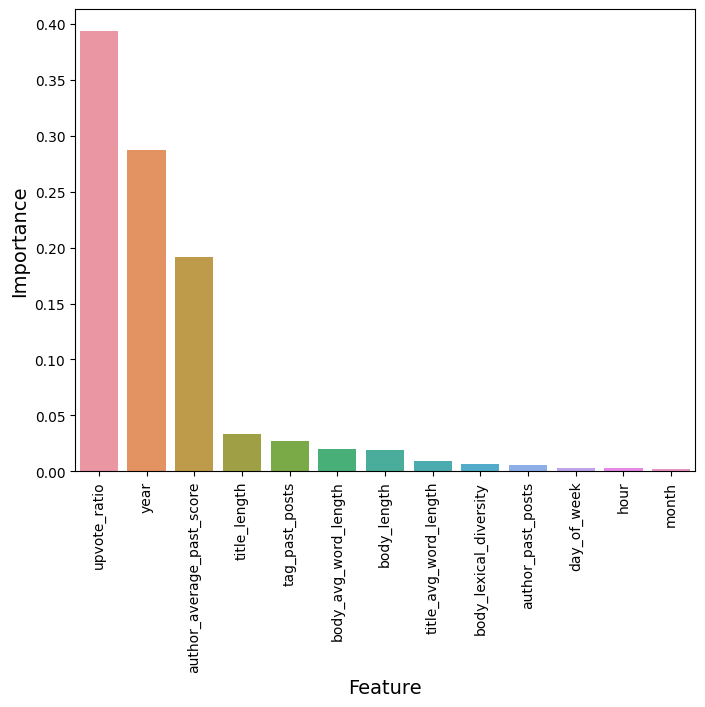

In [35]:
# plot feature importances
fig, axes = plt.subplots(figsize=(8, 6))
bp = sns.barplot(x=feature_importance_df['feature'], 
                 y=feature_importance_df['importance'],
                 ax=axes, errorbar=None, orient='v')
plt.setp(bp.get_xticklabels(), rotation=90)
axes.set_xlabel('Feature', fontsize=14)
axes.set_ylabel('Importance', fontsize=14)

ValueError: Could not interpret value `log_score` for parameter `y`

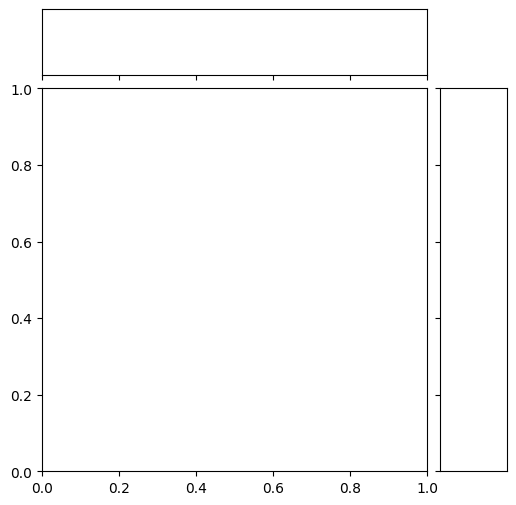

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the joint plot with KDE
joint_plot = sns.jointplot(data=df, x='upvote_ratio', y='log_score', kind='kde', cmap='coolwarm')

# Add grid lines
plt.grid()



In [ ]:
df.columns

In [ ]:
df.to_csv('data_features.csv', index=False)